In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline

plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.axisbelow'] = True

import warnings
warnings.filterwarnings("ignore")

In [2]:
surface = pd.read_csv('ttc_surface_route_delays.csv')
weather = pd.read_csv('weather.csv')
holidays = pd.read_csv('holidays.csv')

In [ ]:
surface.head()

In [ ]:
holidays.head()

In [ ]:
weather.head()

In [ ]:
surface.info()

In [3]:
surface['Report Date'] = pd.to_datetime(surface['Report Date'])
surface['Month'] = surface['Report Date'].dt.month
surface['nDay'] = surface['Report Date'].dt.day
surface = surface.rename(columns={'Report Date': 'Date'})
surface = surface.drop(columns=['Unnamed: 0'])

weather['Date/Time'] = pd.to_datetime(weather['Date/Time'])
weather = weather.rename(columns={
    'Date/Time': 'Date', 
    'Mean Temp (°C)': 'Mean Temp', 
    'Total Precip (mm)': 'Precipitation'
})
weather = weather.drop(columns={'Year', 'Month', 'Day'})

holidays = holidays.rename(columns={'date': 'Date', 'holiday': 'Holiday'})
holidays['Date'] = pd.to_datetime(holidays['Date'])

In [4]:
surface = pd.merge(surface, weather, on='Date', how='left')
surface = pd.merge(surface, holidays, on='Date', how='left')
surface.sort_values('Min Delay', ascending=False).head(3)

,Date,Route,Time,Day,Location,Incident,Min Delay,Min Gap,Direction,Vehicle,...,Month,nDay,Max Temp (°C),Min Temp (°C),Mean Temp,Total Rain (mm),Total Snow (cm),Precipitation,Snow on Grnd (cm),Holiday
345522,2014-03-03,41,20.92,Saturday,West Toronto and Keele,Diversion,246245.0,260.0,b/w,1619.0,...,3,3,-11.42,-19.28,-15.38,0.00,0.00,0.04,18.4,NaN
214581,2016-07-26,506,5.67,Sunday,Howardpark and Dundas,Diversion,6518.0,6528.0,B/W,7403.0,...,7,26,29.50,17.58,23.56,0.00,0.00,0.00,0.0,NaN
269609,2015-03-21,32,5.00,Thursday,Eglinton and Richardson,Diversion,5775.0,5783.0,b/w,NaN,...,3,21,6.28,-4.36,1.00,1.36,0.04,2.90,0.0,NaN


In [5]:
surface['Holiday'] = surface['Holiday'].fillna('None')
surface = surface[surface['Min Delay'] < 7000]
surface['Route'] = surface['Route'].astype('category')
surface['Vehicle'] = surface['Vehicle'].astype('category')

In [6]:
surface.sort_values('Min Delay', ascending=False).head(5)

,Date,Route,Time,Day,Location,Incident,Min Delay,Min Gap,Direction,Vehicle,...,Month,nDay,Max Temp (°C),Min Temp (°C),Mean Temp,Total Rain (mm),Total Snow (cm),Precipitation,Snow on Grnd (cm),Holiday
214581,2016-07-26,506,5.67,Sunday,Howardpark and Dundas,Diversion,6518.0,6528.0,B/W,7403.0,...,7,26,29.50,17.58,23.56,0.00,0.00,0.00,0.0,None
269609,2015-03-21,32,5.00,Thursday,Eglinton and Richardson,Diversion,5775.0,5783.0,b/w,NaN,...,3,21,6.28,-4.36,1.00,1.36,0.04,2.90,0.0,None
342694,2014-02-21,73,18.37,Wednesday,ALBION & ISLINGTON,Diversion,3780.0,398.0,S,8044.0,...,2,21,4.62,0.04,2.34,2.04,0.00,5.54,18.8,None
414903,2014-12-02,73,14.42,Sunday,LAROSE AND SCARLETT RD,Diversion,3380.0,368.0,S,8025.0,...,12,2,1.74,-9.94,-4.12,0.00,0.68,0.76,0.0,None
390748,2014-09-04,172,10.62,Tuesday,Parliament and Front,Diversion,2430.0,2650.0,w,7830.0,...,9,4,28.72,15.80,22.30,0.00,0.00,0.00,0.0,None


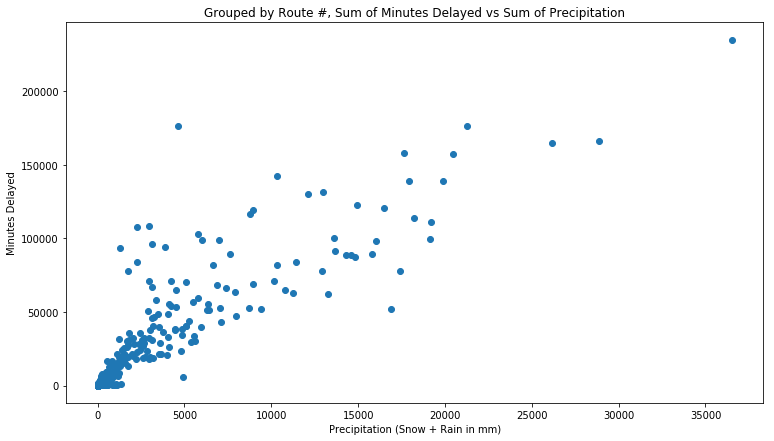

In [7]:
routes = surface.groupby('Route').agg({'Min Delay': 'sum', 'Precipitation': 'sum'})
routes

fig, ax = plt.subplots(1, figsize = [12.5, 7])

ax.scatter(routes['Precipitation'], routes['Min Delay'])

ax.set_ylabel('Minutes Delayed')
ax.set_xlabel('Precipitation (Snow + Rain in mm)')
ax.set_title('Grouped by Route #, Sum of Minutes Delayed vs Sum of Precipitation')

plt.show()

<center><h2>Exploratory Scatterplot</center</h2>

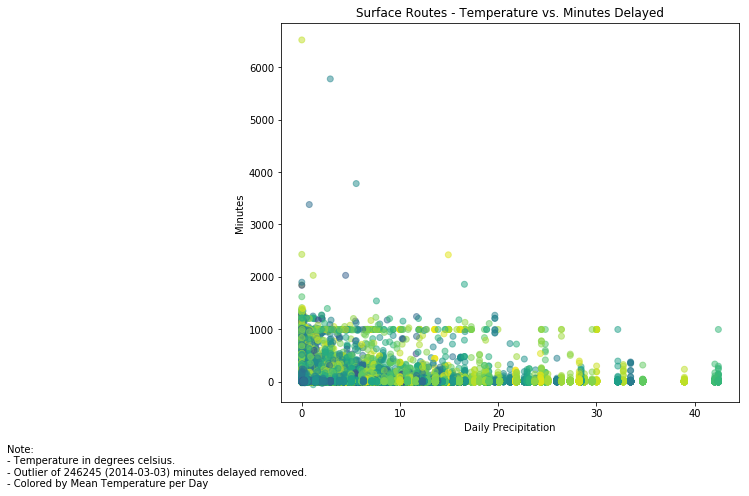

In [8]:
fig, ax = plt.subplots(1, figsize = [12.5, 7])

ax.scatter(
    surface['Precipitation'], 
    surface['Min Delay'], 
    c=surface['Mean Temp'], 
    alpha = 0.5
)

ax.set_ylabel('Minutes')
ax.set_xlabel('Daily Precipitation')
ax.set_title('Surface Routes - Temperature vs. Minutes Delayed')

plt.text(-30, -2000, 'Note: \
                    \n- Temperature in degrees celsius. \
                    \n- Outlier of 246245 (2014-03-03) minutes delayed removed. \
                    \n- Colored by Mean Temperature per Day')

plt.tight_layout()
plt.savefig('Surface Routes - Temperature vs. Minutes Delayed.png')
plt.show()

In [14]:
vehicles = surface.groupby(['Date', 'Route', 'Vehicle']).agg({'Min Delay': 'sum', 'Min Gap': 'sum', 'Precipitation': 'sum'})
vehicles = vehicles.rename(columns={'Min Delay': 'Total Minutes', 'Min Gap': 'Total Gap'}).reset_index()
vehicles.head(10)

,Date,Route,Vehicle,Total Minutes,Total Gap,Precipitation
0,2014-01-03,5,8337.0,15.0,30.0,0.04
1,2014-01-03,6,1534.0,26.0,52.0,0.08
2,2014-01-03,7,8169.0,9.0,18.0,0.04
3,2014-01-03,7,8194.0,9.0,18.0,0.04
4,2014-01-03,9,7882.0,20.0,40.0,0.04
5,2014-01-03,10,8331.0,1.0,1.0,0.04
6,2014-01-03,12,7886.0,50.0,100.0,0.08
7,2014-01-03,21,7740.0,16.0,32.0,0.04
8,2014-01-03,24,7843.0,10.0,20.0,0.04
9,2014-01-03,25,7612.0,6.0,12.0,0.04


In [10]:
vehicles['Total Minutes'].mean(), vehicles['Total Gap'].mean()

(17.07953717044626, 27.11892775529139)

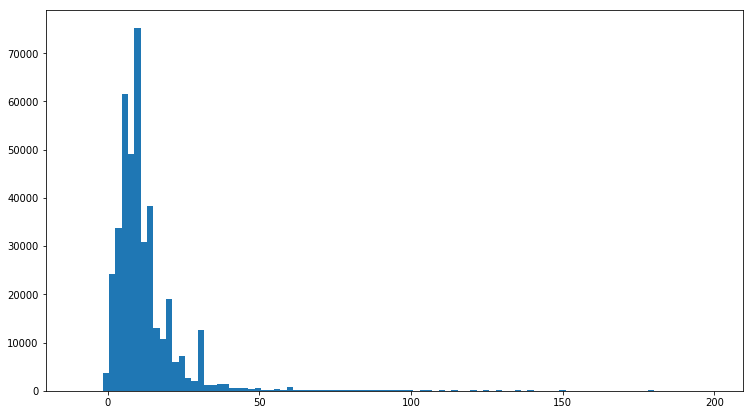

In [15]:
vehicles = vehicles[vehicles['Total Minutes'] < 200]

fig, ax = plt.subplots(1, figsize=[12.5, 7])

ax.hist(vehicles['Total Minutes'], bins = 100)

plt.show()

<center><h2>Delay Time</h2></center>

In [ ]:
groupedbyday = surface.groupby(['Date', 'Day']).agg({'Min Delay': 'sum'})
groupedbyday = groupedbyday.reset_index()
groupedbyday

In [ ]:


fig, ax = plt.subplots(1, figsize = [12.5, 7])

ax.hist(groupedbyday['Min Delay'], bins = 100)

plt.show()

In [ ]:
groupedbyday.mean(), groupedbyday.median()

In [ ]:
totaldays = len(groupedbyday)
totalmin = groupedbyday['Min Delay'].sum()
meanminperday = round(groupedbyday['Min Delay'].mean(), 2)
medianminperday = round(groupedbyday['Min Delay'].median(), 2)
daysdelay = round((groupedbyday['Min Delay'].sum()/60)/24, 2)
percdelay = round((daysdelay / totaldays)/100, 2)
sigmaday = round(groupedbyday['Min Delay'].std(), 2)
delayvariance = round(sigmaday ** 2, 2)

delaystats_dict = {
    'Total Days': totaldays,
    'Total Minutes': daysdelay,
    'Mean Min. per Day': meanminperday,
    'Median Min. per Day': medianminperday,
    '% of Days Delayed': percdelay,
    'Daily Sigma': sigmaday,
    'Delay Variance': delayvariance
}

delaystats = pd.DataFrame(delaystats_dict, index=['Stats'])

delaystats = delaystats.style.format({
    '% of Days Delayed': '{:.2%}'.format
})

In [ ]:
totaldays, totalmin, meanminperday, medianminperday, daysdelay, percdelay, sigmaday, delayvariance

In [ ]:
delaystats

In [ ]:
surface.head()

In [13]:
incidents = surface.groupby('Incident').agg({'Min Delay': 'sum', 'Min Gap': 'sum'}).sort_values('Min Delay')
incidents = incidents.reset_index()
incidents

,Incident,Min Delay,Min Gap
0,Late Leaving Garage - Management,41.0,83.0
1,Late Leaving Garage - Operator,251.0,422.0
2,Late Leaving Garage - Mechanical,545.0,991.0
3,Vision,708.0,1657.0
4,Overhead - Pantograph,4680.0,5750.0
5,Emergency Services,150622.0,262087.0
6,Held By,185078.0,242711.0
7,Utilized Off Route,587816.0,1146809.0
8,Investigation,626181.0,1125308.0
9,Late Leaving Garage,726278.0,1355711.0


In [ ]:
names = incidents['Incident'].unique().tolist()
names

In [ ]:
bar1 = weekdays['Min Delay']
bar2 = weekdays['Min Gap']

label = weekdays['Day']
barwidth = 1
names = weekdays['Day'].unique().tolist()
dayorder = [1, 5, 6, 4, 0, 2, 3]
names = [names[i] for i in dayorder]

In [ ]:
bar1 = incidents['Min Delay']
bar2 = incidents['Min Gap']

label = incidents['Incident']
barwidth = 1

description = incidents['Incident'].unique().tolist()
description_order = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
descriptions = [description[i] for i in description_order]

bars = np.add(bar1, bar2).tolist()

fig, ax = plt.subplots(1, figsize = [12.5, 10])

p1 = ax.bar(label, bar1, color='#800000', edgecolor='white', width=barwidth)
p2 = ax.bar(label, bar2, bottom=bar1, color='#888888', edgecolor='white', width=barwidth)

ax.set_ylabel('Minutes')
ax.set_xlabel('Days of the Week')
ax.set_title('Sum of Minutes per Delay Description')

plt.legend((p1[0], p2[0]), ('Minutes Delayed', 'Gap in Minutes'))

plt.xticks(label, descriptions, rotation = 35)

plt.tight_layout()

plt.savefig('Sum of Minutes per Delay Description.png')
plt.show()